<a href="https://colab.research.google.com/github/JP12468/CRmap/blob/main/CRmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

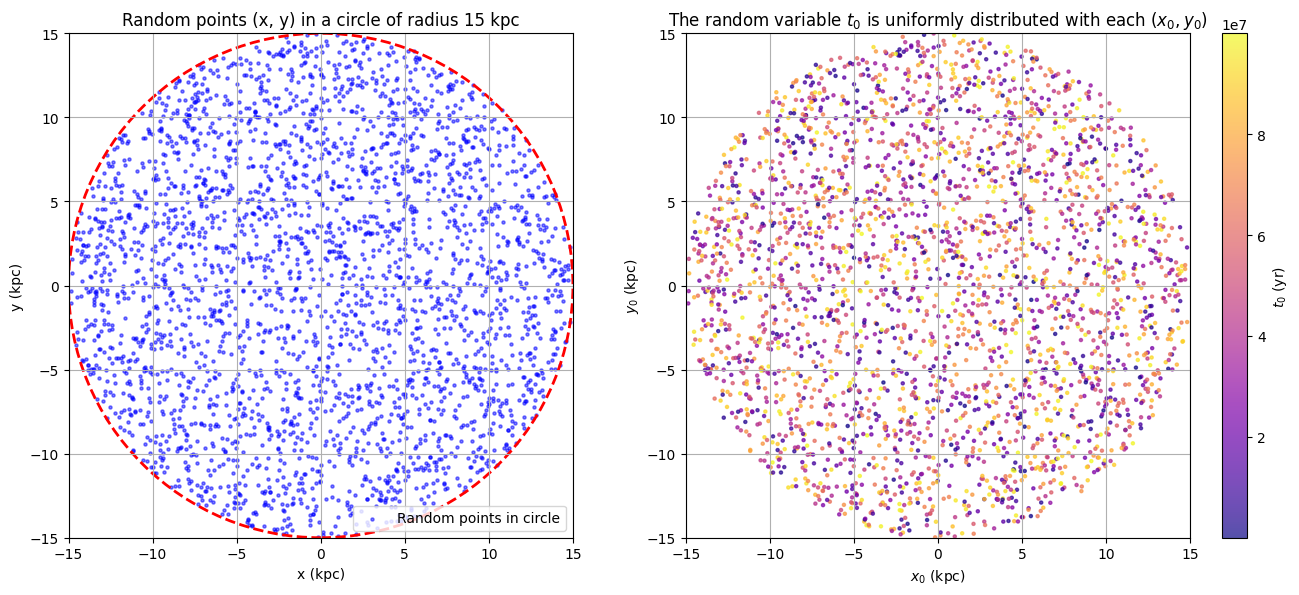

In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit

# Constants
radius = 15
N_points = 3000

# Initialize the random number generator in JAX
key = random.PRNGKey(0)
key_theta, key_r, key_t = random.split(key, 3)

# Sample points (x0, y0) inside a circle of radius 15 kpc
theta = random.uniform(key_theta, (N_points,), minval=0, maxval=2 * jnp.pi)
r = radius * jnp.sqrt(random.uniform(key_r, (N_points,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)

# Sample time t0 uniformly in the interval (0, 10^8) years
t0 = random.uniform(key_t, (N_points,), minval=0, maxval=1e8)

# Plot the distribution of points (x0, y0) inside the circle
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot (x0, y0)
axes[0].scatter(x0, y0, s=5, alpha=0.5, color='blue', label="Random points in circle")
circle = plt.Circle((0, 0), radius, color='red', fill=False, linestyle='dashed', linewidth=2)
axes[0].add_patch(circle)
axes[0].set_aspect('equal')
axes[0].set_xlim(-radius, radius)
axes[0].set_ylim(-radius, radius)
axes[0].set_xlabel("x (kpc)")
axes[0].set_ylabel("y (kpc)")
axes[0].set_title("Random points (x, y) in a circle of radius 15 kpc")
axes[0].legend()
axes[0].grid(True)

plt.tight_layout()

# Scatter plot colored by t0
sc = plt.scatter(x0, y0, c=t0, cmap='plasma', s=5, alpha=0.7)
circle = plt.Circle((0, 0), radius, color='red', fill=False, linestyle='dashed', linewidth=2)
plt.colorbar(sc, label=r'$t_0$ (yr)')
plt.xlabel('$x_0$ (kpc)')
plt.ylabel('$y_0$ (kpc)')
plt.title('The random variable $t_0$ is uniformly distributed with each $(x_0,y_0)$')
plt.xlim(-radius, radius)
plt.ylim(-radius, radius)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()


In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit

# Constants
R = 15  # kpc
L = 4   # kpc
z0 = 0
kappa = 4.429 * 1e-6
Q_E = 4.175 * 1e30
t_max = L**2 / (2 * kappa)
N_sources = 1e4

# Initialize the random number generator in JAX
key = random.PRNGKey(0)
key_theta, key_r, key_t = random.split(key, 3)

# Sample points (x0, y0) inside a circle of radius 15 kpc
theta = random.uniform(key_theta, (N_sources,), minval=0, maxval=2 * jnp.pi)
r = R * jnp.sqrt(random.uniform(key_r, (N_sources,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)

# Sample time t0 in the interval (0, τ_max)
t0 = random.uniform(key_t, (N_sources,), minval=0, maxval=t_max)

# Spatial grid for plotting the map
x_grid = jnp.linspace(-R, R, 150)
y_grid = jnp.linspace(-R, R, 150)
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing='ij')

# 3D Green's function
@jit
def G(t, x, y, x0, y0, t0, kappa_E):
    tau = t - t0
    tau = jnp.where(tau > 0, tau, 1e-6)

    n_values = jnp.arange(-10, 10)
    zn = 2 * n_values * L + (-1) ** n_values * z0
    exponent = -((x - x0) ** 2 + (y - y0) ** 2 + zn ** 2) / (4 * kappa_E * tau)

    psi_n = ((-1) ** n_values * Q_E / ((4 * jnp.pi * kappa_E * tau) ** (3 / 2))) * jnp.exp(exponent)
    return jnp.sum(psi_n)

# Vectorize G
G_vmap = jit(vmap(G, in_axes=(None, 0, 0, None, None, None, None), out_axes=0))

# Compute cosmic-ray density f_CR(x, y, z=0)
t_current = t_max
f_CR = jnp.zeros_like(x_mesh)

# Vectorize the entire computation
@jit
def compute_f_CR(x_mesh, y_mesh, x0, y0, t0, kappa, t_current):
    def single_source_contribution(x, y, x0, y0, t0):
        return G_vmap(t_current, x, y, x0, y0, t0, kappa)

    f_CR_total = vmap(single_source_contribution, in_axes=(None, None, 0, 0, 0))(x_mesh.ravel(), y_mesh.ravel(), x0, y0, t0)
    return jnp.sum(f_CR_total, axis=0).reshape(x_mesh.shape)

f_CR = compute_f_CR(x_mesh, y_mesh, x0, y0, t0, kappa, t_current)

# Plot the density map
plt.figure(figsize=(8, 6))
c = plt.contourf(x_grid, y_grid, f_CR, levels=100, cmap='inferno')
plt.colorbar(c, label='$f_{CR}(x,y,z=0)$')
plt.xlabel('$x$ (kpc)')
plt.ylabel('$y$ (kpc)')
plt.title('The map of cosmic-ray density $f_{CR}(x,y,z=0)$')
plt.show()


TypeError: Shapes must be 1D sequences of concrete values of integer type, got (10000.0,).

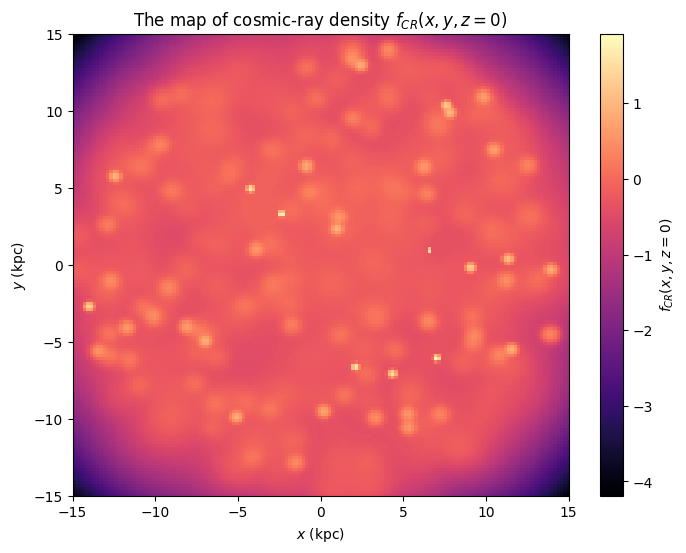

In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit, device_put

# Constants
R = 15  # kpc
L = 4   # kpc
z0 = 0
kappa = 4.429 * 1e-5
Q_E = 1
# t_max = L**2 / (2*kappa)  # τ_max = L^2 / (2κ)
t_max = 5 * 10**4
N_sources = int(0.03 * t_max)  # Increase to 1 million sources

# Initialize random number generator
key = random.PRNGKey(0)
key_theta, key_r, key_t = random.split(key, 3)

# Sample points (x0, y0) inside a circle of radius R
theta = random.uniform(key_theta, (N_sources,), minval=0, maxval=2 * jnp.pi)
r = R * jnp.sqrt(random.uniform(key_r, (N_sources,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)

# Sample time t0 in the interval (0, τ_max)
t0 = random.uniform(key_t, (N_sources,), minval=0, maxval=t_max)

# Spatial grid
grid_size = 150
x_grid = jnp.linspace(-R, R, grid_size)
y_grid = jnp.linspace(-R, R, grid_size)
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing='ij')

# Optimized 3D Green's function
@jit
def G(t, x, y, x0, y0, t0, kappa_E):
    tau = jnp.maximum(t - t0, 1e-6)  # Ensure tau > 0
    n_values = jnp.arange(-10, 11)  # Reduce number of n terms for speed
    zn = 2 * n_values * L + (-1) ** n_values * z0
    exponent = -((x - x0) ** 2 + (y - y0) ** 2 + zn ** 2) / (4 * kappa_E * tau)
    psi_n = ((-1) ** n_values * Q_E / ((4 * jnp.pi * kappa_E * tau) ** (3 / 2))) * jnp.exp(exponent)
    return jnp.sum(psi_n)

# Vectorize over (x, y)
G_vmap = jit(vmap(G, in_axes=(None, 0, 0, None, None, None, None), out_axes=0))

# Compute cosmic-ray density f_CR
@jit
def compute_f_CR(x_mesh, y_mesh, x0, y0, t0, kappa, t_current):
    def single_source_contribution(x, y, x0, y0, t0):
        return G_vmap(t_current, x, y, x0, y0, t0, kappa)

    # Batch processing over sources
    batch_size = 1000
    f_CR_total = jnp.zeros(x_mesh.ravel().shape)

    for i in range(0, len(x0), batch_size):
        f_CR_partial = vmap(single_source_contribution, in_axes=(None, None, 0, 0, 0))(
            x_mesh.ravel(), y_mesh.ravel(), x0[i:i+batch_size], y0[i:i+batch_size], t0[i:i+batch_size]
        )
        f_CR_total += jnp.sum(f_CR_partial, axis=0)

    return f_CR_total.reshape(x_mesh.shape)

# Put data on GPU
x_mesh, y_mesh = device_put((x_mesh, y_mesh))
x0, y0, t0 = device_put((x0, y0, t0))

# Compute f_CR on GPU
t_current = t_max
f_CR = compute_f_CR(x_mesh, y_mesh, x0, y0, t0, kappa, t_current)

plt.figure(figsize=(8, 6))

# Use imshow instead of contourf
plt.imshow(jnp.log10(jnp.nan_to_num(f_CR)).T, origin="lower", extent=[-15, 15, -15, 15], cmap='magma', aspect='auto')  # , vmin=30, vmax=34.5

# Add colorbar
plt.colorbar(label='$f_{CR}(x,y,z=0)$')

# Labels and title
plt.xlabel('$x$ (kpc)')
plt.ylabel('$y$ (kpc)')
plt.title('The map of cosmic-ray density $f_{CR}(x,y,z=0)$')

# Show plot
plt.show()


Cosmic Ray Density at Earth (x=8.5, y=0):
  E = 1.0e+13 eV : f_CR = 2.099e+02 eV⁻¹ cm⁻³
  E = 1.0e+14 eV : f_CR = 7.329e-01 eV⁻¹ cm⁻³
  E = 1.0e+15 eV : f_CR = 3.231e-03 eV⁻¹ cm⁻³


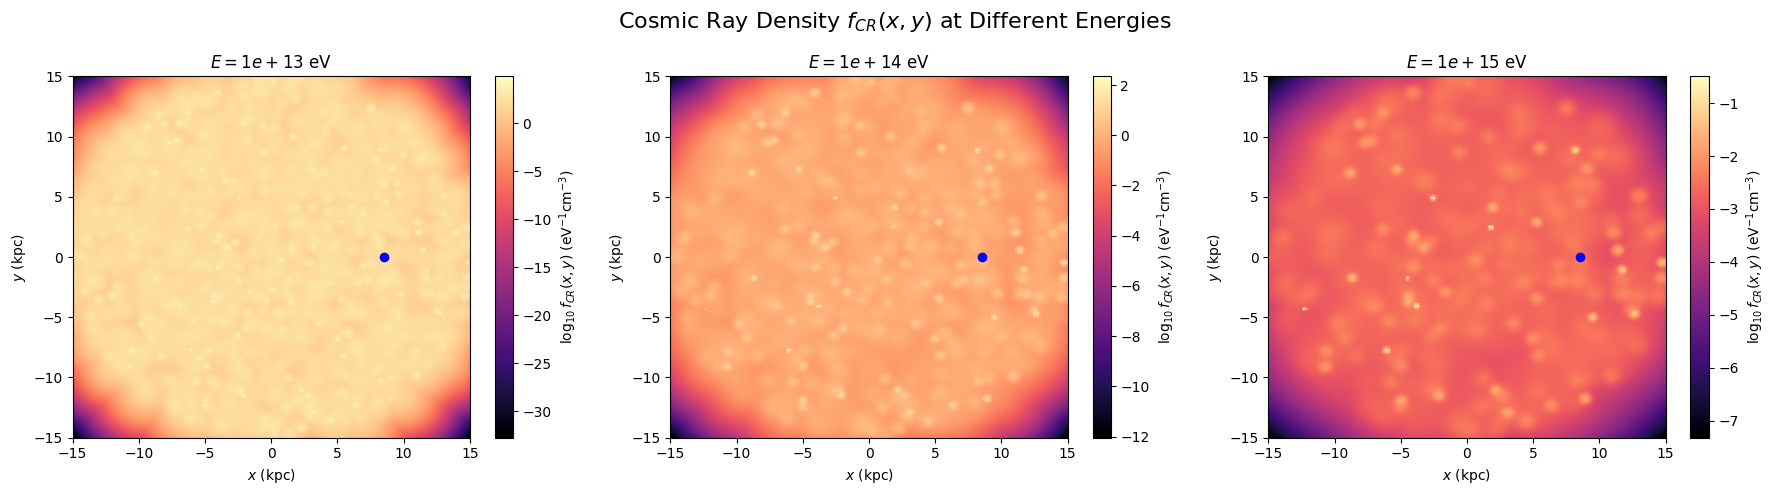

In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit
from jax.scipy.ndimage import map_coordinates
import jax
jax.config.update("jax_enable_x64", True)

# Constants
R = 15  # kpc
L = 4   # kpc
z0 = 0
t_max = 5e4
N_sources = int(0.03 * t_max)  # Increased number of sources

# Random number generator
key = random.PRNGKey(0)
key_theta, key_r, key_t = random.split(key, 3)

# Sample (x0, y0) in a circular disk
theta = random.uniform(key_theta, (N_sources,), minval=0, maxval=2 * jnp.pi)
r = R * jnp.sqrt(random.uniform(key_r, (N_sources,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)

# Sample t0 in (0, t_max)
t0 = random.uniform(key_t, (N_sources,), minval=0, maxval=t_max)

# Grid setup
grid_size = 150
x_grid = jnp.linspace(-R, R, grid_size)
y_grid = jnp.linspace(-R, R, grid_size)
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing='ij')

# Flatten mesh grids for vectorization
x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()

# Diffusion coefficient kappa(E) in cm^2/Myr
def kappa(E):
    kappa_0 = 3.3e-8  # kpc^2 / Myr (diffusion coefficient constant)
    m_p_c2 = 0.938e9    # Proton rest energy in eV
    beta = 1  # Given in the problem


    # Calculate kappa(E) based on energy E in eV
    x = E / m_p_c2
    kappa_E = kappa_0 * beta * jnp.sqrt(jnp.sqrt(x**2 - 1))

    # kappa(E) now in units of cm^2 / Myr
    return kappa_E

# Adjust source spectrum Q(E) with proper units
def Q(E):
    alpha = 4.23
    xi_CR = 8.7 / 100  # Convert percentage to fraction
    E_SNR = 6.242e62  # in eV, from 10^51 erg
    m_p_c2 = 0.938e9  # Proton rest energy in eV
    Lambda = 4.111  # Normalization constant
    beta = 1  # Given in the problem

    x = E / m_p_c2
    Q_E = (xi_CR * E_SNR) / ((m_p_c2) ** 2 * Lambda * beta) * (jnp.sqrt(x**2 - 1)) ** (2 - alpha)

    return Q_E

# Green's function G
@jit
def G(x, y, x0, y0, t0, t, E):
    tau = jnp.maximum(t - t0, 1e-6)  # Ensure tau > 0
    n_values = jnp.arange(-50, 51)
    zn = 2 * n_values[:, None] * L + (-1) ** n_values[:, None] * z0  # Shape (101, 1)

    # Compute exponent term with broadcasting
    exponent = -((x - x0) ** 2 + (y - y0) ** 2 + zn ** 2) / (4 * kappa(E) * tau)
    psi_n = ((-1) ** n_values[:, None] * Q(E) / ((4 * jnp.pi * kappa(E) * 3.086e21 * tau) ** (3 / 2))) * jnp.exp(exponent)

    return jnp.sum(psi_n, axis=0)  # Sum over n to collapse dimension

# Vectorized G over (x, y)
G_vmap = jit(vmap(G, in_axes=(None, None, 0, 0, 0, None, None), out_axes=0))

# Precompute G values efficiently
@jit
def precompute_G(x_flat, y_flat, x0, y0, t0, t_current, E):
    f_CR_total = vmap(G, in_axes=(None, None, 0, 0, 0, None, None))(
        x_flat, y_flat, x0, y0, t0, t_current, E)
    return jnp.sum(f_CR_total, axis=0).reshape(grid_size, grid_size)

# JAX-compatible interpolation of G
def interpolate_G(x_mesh, y_mesh, x_grid, y_grid, f_CR):
    x_indices = (x_mesh - x_grid[0]) / (x_grid[-1] - x_grid[0]) * (grid_size - 1)
    y_indices = (y_mesh - y_grid[0]) / (y_grid[-1] - y_grid[0]) * (grid_size - 1)
    x_indices = jnp.clip(x_indices, 0, grid_size - 1)
    y_indices = jnp.clip(y_indices, 0, grid_size - 1)
    return map_coordinates(f_CR, [x_indices, y_indices], order=1)

# Compute precomputed G values
t_current = t_max
E_values = [1e13, 1e14, 1e15]
f_CR_list = []

for E in E_values:
    f_CR_E = precompute_G(x_flat, y_flat, x0, y0, t0, t_current, E)
    f_CR_list.append(f_CR_E)

# Earth's coordinates
x_earth = 8.5  # kpc
y_earth = 0.0  # kpc

# Find closest grid indices
ix = jnp.argmin(jnp.abs(x_grid - x_earth))
iy = jnp.argmin(jnp.abs(y_grid - y_earth))

# Print CR density at Earth
print("Cosmic Ray Density at Earth (x=8.5, y=0):")
for E, f_CR_E in zip(E_values, f_CR_list):
    f_val = f_CR_E[ix, iy]
    print(f"  E = {E:.1e} eV : f_CR = {f_val:.3e} eV$^{-1}$cm$^{-3}")

# Plot f_CR(x, y) maps for each energy
fig, axs = plt.subplots(1, len(E_values), figsize=(18, 5))
for i, (E, f_CR_E) in enumerate(zip(E_values, f_CR_list)):
    im = axs[i].imshow(
        jnp.log10(jnp.nan_to_num(f_CR_E)).T,
        origin="lower",
        extent=[-R, R, -R, R],
        cmap='magma',
        aspect='auto'
    )
    axs[i].plot(x_earth, y_earth, 'bo', label='Earth')
    axs[i].set_title(f'$E = {E:.0e}$ eV')
    axs[i].set_xlabel('$x$ (kpc)')
    axs[i].set_ylabel('$y$ (kpc)')
    fig.colorbar(im, ax=axs[i], label='$\log_{10} f_{CR}(x,y)$ (eV$^{-1}$cm$^{-3}$)')

plt.suptitle("Cosmic Ray Density $f_{CR}(x,y)$ at Different Energies", fontsize=16)
plt.tight_layout()
plt.show()